# Project 2 - Using Feed-Forward Neural Networks for linear and logistic regression

## **Part a)** - Stochastic Gradient Descent
### Main program
#### Program imports and defaults

In [11]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Random seed
def_seed = 1
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

#### Dataset setup

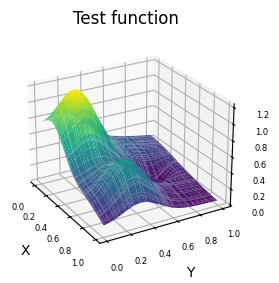

In [12]:
cases = ['1D','2D','Franke']
case_ = cases[2]
show = False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 100, 100                                          # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
if case_ == '1D':
    f = dataset.plot(labels=['Test function','x','y','dataset','true'])
else:
    f = dataset.plot(labels=['Test function','X','Y','Z'])

if case_ == '1D':
    targets = dataset.target[0]
    inputs = dataset.x

else:
    targets = dataset.target_f
    x = dataset.xf; y = dataset.yf
    inputs = anp.zeros((x.shape[0],2))
    inputs[:,0] = x[:,0]
    inputs[:,1] = y[:,0] 


### Gradient Descent Analysis
#### Plain GD and GD with momentum

(8000, 8)
Method: PlainGD
MSE, SGD
0.06162044490347338
MSE, Lin.Reg
0.061369633338265825 

(10000, 1)
(100, 100)
(100, 100)
Method: MomentumGD
MSE, SGD
0.06198489330106233
MSE, Lin.Reg
0.061369633338265825 

(10000, 1)
(100, 100)
(100, 100)


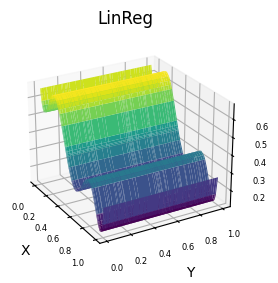

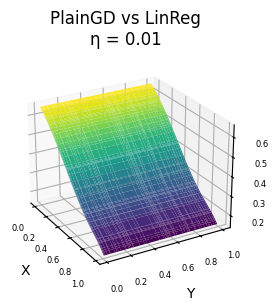

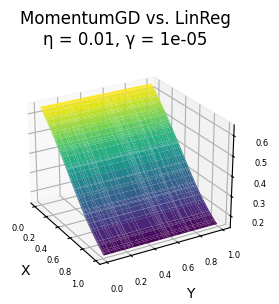

In [10]:
## Regression setup and initialization
eta = 0.01; n_iter = 10; lmbda = 0.0001

lin_gd = LinearRegressor(learning_rate=eta,num_iterations=n_iter)

## Design matrix
poly_deg = 7
if case_ == '1D':
    X = lin_gd.design_matrix(x=inputs,poly_deg=poly_deg,intercept=True)
    #X_train = lin_gd.design_matrix(x=inputs_train_s,poly_deg=poly_deg,intercept=True)
    #X_test = lin_gd.design_matrix(x=inputs_test_s,poly_deg=poly_deg,intercept=True)
else:
    X = lin_gd.design_matrix(x=inputs,poly_deg=poly_deg,intercept=True)
    #X_train = lin_gd.design_matrix(x=inputs_train_s,poly_deg=poly_deg,intercept=True)
    #X_test = lin_gd.design_matrix(x=inputs_test_s,poly_deg=poly_deg,intercept=True)

test_size = 1/5
inputs_train, inputs_test, targets_train, targets_test = train_test_split(X,targets,test_size=test_size,random_state=def_seed)
#inputs_train, inputs_test, targets_train, targets_test = inputs,inputs,targets,targets

## Data scaling
scaler = StandardScaler() # StandardScaler() MinMaxScaler()
scaler.fit(inputs_train)
scale = False
if scale == True:
    inputs_train_s = scaler.transform(inputs_train)
    inputs_test_s = scaler.transform(inputs_test)
else:
    inputs_train_s = inputs_train
    inputs_test_s = inputs_test

print(inputs_train_s.shape)
## Stochastic GD - parameters
batch_size = Nx // 2
batches = int(inputs_train_s.shape[0]/batch_size)
epochs = 1000

if epochs > n_iter:
    n_iter = epochs

mom = [0., 0.00001]
GDMethod = [PlainGD(eta),MomentumGD(eta,momentum=mom[1])]

GradMethod = LassoGrad(lmbda)
#GradMethod = AutoGrad(lmbda,mse_lasso)

## GD-fitting and linear prediction
lin_gd.linear_predict(inputs_train_s,targets_train,predict_type='Ridge',lmbda=lmbda)
prediction_reg = X @ lin_gd.beta_linreg# + lin_gd.intcept
if case_ != '1D':
    pred_reg = prediction_reg.reshape(Nx,Ny)
    lin_gd.plot([dataset.xx,dataset.yy],pred_reg,labels=['LinReg','X','Y','data','SGD','LinReg'])

title_list= ['PlainGD vs LinReg\nη = %g' %(eta),'MomentumGD vs. LinReg\nη = %g, γ = %g' %(eta,mom[1])]

for i,method in enumerate(GDMethod):

    lin_gd.reg_fit(inputs_train_s,targets_train,method,GradMethod,batches=batches,epoch=epochs)

    prediction_gd = X @ lin_gd.beta_gd# + lin_gd.gd_intcept

    print(f'Method: {method.__class__.__name__}')
    if show == True:
        print('β_gd')
        print(lin_gd.beta_gd)
        print('β_lin')

    print('MSE, SGD')
    print(lin_gd.predict(lin_gd.beta_gd,inputs_test_s,targets_test))
    print('MSE, Lin.Reg')
    print(lin_gd.predict(lin_gd.beta_linreg,inputs_test_s,targets_test),'\n')

    if case_ == '1D':
        prediction_gd = X @ lin_gd.beta_gd
        lin_gd.plot(inputs,[targets,prediction_gd,prediction_reg],labels=[title_list[i],'X','Y','data','SGD','LinReg'])
    else:
        prediction_gd = X @ lin_gd.beta_gd
        print(prediction_gd.shape)
        pred_gd = prediction_gd.reshape(Nx,Ny)
        print(pred_gd.shape)
        print(dataset.xx.shape)
        lin_gd.plot([dataset.xx,dataset.yy],pred_gd,labels=[title_list[i],'X','Y','data','SGD','LinReg'])
        #plot2D(dataset.xx,dataset.yy,pred_gd)

    lin_gd.reset()

plt.show()

#### Adagrad, RMSprop and ADAM

In [ ]:
eta_ada, adagrad_mom = 0.01,0.001
eta_rms,rms_decay = 0.001,0.1
eta_ADAM, ADAM_decay = 0.01,[0.9, 0.99]

GDMethod = [Adagrad(eta_ada,momentum=adagrad_mom),RMSprop(eta,decay=rms_decay),ADAM(eta,decay_rates=ADAM_decay)]

title_list = ['Adagrad vs LinReg\neta = %g, Mom = %g'%(eta_ada,adagrad_mom),
              'RMSprop vs. LinReg\neta = %g, rho = %g' %(eta_rms,rms_decay),
              'ADAM vs LinReg\neta = %g, rho = (%g, %g)' %(eta_ADAM,ADAM_decay[0],ADAM_decay[1])]

for i,method in enumerate(GDMethod):

    lin_gd.reg_fit(X_train,targets_train,method,GradMethod,batches=batches,epoch=epochs)

    prediction_gd = X @ lin_gd.beta_gd# + lin_gd.gd_intcept

    print(f'Method: {method.__class__.__name__}')
    if show == True:
        print('β_gd')
        print(lin_gd.beta_gd)
        print('β_lin')
        print(lin_gd.beta_linreg)
    
    print('MSE, SGD')
    print(lin_gd.predict(lin_gd.beta_gd,X_test,targets_test))
    print('MSE, Lin.Reg')
    print(lin_gd.predict(lin_gd.beta_linreg,X_test,targets_test),'\n')

    if case_ == '1D':
        lin_gd.plot(inputs,[targets,prediction_gd,prediction_reg],labels=[title_list[i],'X','Y','data','SGD','LinReg'])
    else:
        pred_gd = prediction_gd.reshape(Nx,Ny)
        lin_gd.plot([dataset.xx,dataset.yy],pred_gd,labels=[title_list[i],'X','Y','data','SGD','LinReg'])

    lin_gd.reset()

plt.show()

#### Study of parameters $\lambda$ and $\eta$

In [ ]:
## Resetting dataset
cases = ['1D','2D','Franke']
case_ = cases[2]
show = False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 100, 100                                          # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
f = dataset.plot(labels=['Test function','x','y','dataset','true'])

In [ ]:
## Regression setup and initialization
num_param = 6
eta = anp.logspace(-7,-1,num_param)
lmbda = anp.logspace(-10,0,num_param+2)
n_iter = 10

decay_rms = 0.9
adagrad_mom = 0.001
ADAM_decay = [0.9, 0.99]

mom = [0., 0.001]
#GDMethod = [PlainGD(eta),MomentumGD(eta,momentum=mom[1])]

## Stochastic GD - parameters
batch_size = Nx // 2
batches = int(Nx/batch_size)
epochs = 1000

poly_deg = 3
lin_pred_type = 'Ridge'

if epochs > n_iter:
    n_iter = epochs

MSE_GD = anp.zeros((len(eta),len(lmbda)))

for i in range(len(eta)):
    for j in range(len(lmbda)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i],num_iterations=n_iter)

        GDMethod =  RMSprop(eta[i],decay=decay_rms)#RMSprop(eta[i],decay=decay_rms) ADAM(eta[i],ADAM_decay) Adagrad(eta[i],momentum=adagrad_mom) #MomentumGD(eta[i],momentum=mom[1]) PlainGD(eta[i])
        GradMethod = RidgeGrad(lmbda[j])

        
        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f#; target_f = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Scaling
        X_s = X#lin_gd.scale(X)
        target_s = target#lin_gd.scale(target)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_s,target_s,predict_type=lin_pred_type,lmbda=lmbda[j])
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_s,target_s,GDMethod,GradMethod,batches=batches,epoch=epochs)

        prediction_gd = X @ lin_gd.beta_gd + lin_gd.gd_intcept

        MSE_GD[i,j] = lin_gd.predict(lin_gd.beta_gd,X,target)

        #print('(i,j): ',i,j)
        #print('l:',lmbda[j])
        #print('e',eta[i])
        #print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))
        
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))

            if case_ != '1D':
                pred_reg = prediction_reg.reshape(Nx,Ny)
                lin_gd.plot([dataset.xx,dataset.yy],pred_reg,labels=[lin_pred_type+'\nλ = %g' %(lmbda[j]),'X','Y','data','SGD','LinReg'])

            if case_ == '1D':
                lin_gd.plot(x,[target,prediction_gd,prediction_reg],labels=[f"{GDMethod.__class__.__name__}\nη={eta[i]}, λ={lmbda[j]}",'X','Y','data','SGD','LinReg'])
            else:
                pred_gd = prediction_gd.reshape(Nx,Ny)
                lin_gd.plot([dataset.xx,dataset.yy],pred_gd,labels=[f"{GDMethod.__class__.__name__}\nη={eta[i]}, λ={lmbda[j]}",'X','Y','data','SGD','LinReg'])

        lin_gd.reset()

fig0,ax = lambda_eta(MSE_GD,[lmbda,eta],
                axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_GD.min(),MSE_GD.max()]
                )

_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')


In [ ]:
fig,ax = lambda_eta(MSE_GD,[lmbda,eta],
                axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_GD.min(),MSE_GD.max()],
                cmap='hot_r'
                )

fig.set_size_inches(7,3)
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')

In [ ]:
fig.savefig('grid_search_sgd_rms_eta_lam.png',dpi=300,bbox_inches='tight')

#### Adagrad-momentum and learning rate tuning

In [ ]:
num_param = 6
eta = anp.logspace(-7,-1,num_param)
adagrad_mom = anp.logspace(-10,-1,num_param+2)

lmbda_ada = 2e-3  # From study above

MSE_GD = anp.zeros((len(eta),len(lmbda)))

for i in range(len(eta)):
    for j in range(len(adagrad_mom)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i],num_iterations=n_iter)

        GDMethod = Adagrad(eta[i],momentum=adagrad_mom[j])
        GradMethod = RidgeGrad(lmbda_ada)

        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f#; target_f = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Scaling
        X_s = X#lin_gd.scale(X)
        target_s = target#lin_gd.scale(target)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_s,target_s,predict_type=lin_pred_type,lmbda=lmbda_ada)
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_s,target_s,GDMethod,GradMethod,batches=batches,epoch=epochs)

        prediction_gd = X @ lin_gd.beta_gd + lin_gd.gd_intcept

        MSE_GD[i,j] = lin_gd.predict(lin_gd.beta_gd,X,target)

        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Momentum,      γ:',adagrad_mom[j])
            print('Learning rate, η:',eta[i])
            print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))

        lin_gd.reset()

fig,ax = lambda_eta(MSE_GD,[adagrad_mom,eta],
                axis_tick_labels=[[f'{y:.0e}' for y in adagrad_mom],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_GD.min(),MSE_GD.max()]
                )

ax.set_title(f'{GDMethod.__class__.__name__}: MSE for γ vs. η\nλ = %.0e'%(lmbda_ada))
_ = ax.set_xlabel('γ')

#### RMSprop Decay rate, $\rho$ and learning rate, $\eta$, tuning

In [ ]:
num_param = 6
eta = anp.logspace(-2,0,num_param)
decay = anp.linspace(0.01,0.9,num_param+2)

lmbda_rms = 2e-10  # From study above

MSE_GD = anp.zeros((len(eta),len(decay)))

for i in range(len(eta)):
    for j in range(len(decay)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i],num_iterations=n_iter)

        GDMethod = RMSprop(eta[i],decay=decay[j])
        GradMethod = RidgeGrad(lmbda_rms)

        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f#; target_f = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Scaling
        X_s = X#lin_gd.scale(X)
        target_s = target#lin_gd.scale(target)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_s,target_s,predict_type=lin_pred_type,lmbda=lmbda_rms)
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_s,target_s,GDMethod,GradMethod,batches=batches,epoch=epochs)

        prediction_gd = X @ lin_gd.beta_gd + lin_gd.gd_intcept

        MSE_GD[i,j] = lin_gd.predict(lin_gd.beta_gd,X,target)

        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Decay rate,    ρ:',decay[j])
            print('Learning rate, η:',eta[i])
            print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))

        lin_gd.reset()

fig,ax = lambda_eta(MSE_GD,[decay,eta],
                axis_tick_labels=[[f'{y:.1f}' for y in decay],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_GD.min(),MSE_GD.max()]
                )

ax.set_title(f'{GDMethod.__class__.__name__}: MSE for ρ vs. η\nλ = %.0e'%(lmbda_rms))
_ = ax.set_xlabel('ρ')

#### Mini-batching and Epoch - study
This part shows results from one SGD-method varying the size of the batchs and number of epochs, together with learning rate

In [ ]:
## Resetting dataset
cases = ['1D','2D','Franke']
case_ = cases[2]
show = False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 40, 40                                          # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
f = dataset.plot(labels=['Test function','x','y','dataset','true'])

In [ ]:
## Regression setup and initialization
num_param = 6
eta = anp.logspace(-7,-1,num_param)
lmbda = 1e-5 #anp.logspace(-10,0,num_param+2)

decay_rms = 0.9
adagrad_mom = 0.001
ADAM_decay = [0.9, 0.99]

mom = [0., 0.001]

## Stochastic GD - parameters
batches = [2,10,15,20,30,40]
epochs = [10,100,500,1000,5000,10000]
batch = batches[3]; epoch = epochs[-2]

poly_deg = 6
lin_pred_type = 'Ridge'

MSE_BATCH = anp.zeros((len(eta),len(batches)))
MSE_EPOCH = anp.zeros((len(eta),len(epochs)))

for i in range(len(eta)):
    for j in range(len(batches)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i])

        GDMethod =  RMSprop(eta[i],decay=decay_rms)#RMSprop(eta[i],decay=decay_rms) ADAM(eta[i],ADAM_decay) Adagrad(eta[i],momentum=adagrad_mom) #MomentumGD(eta[i],momentum=mom[1]) PlainGD(eta[i])
        GradMethod = RidgeGrad(lmbda)

        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f#; target_f = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Scaling
        X_s = X#lin_gd.scale(X)
        target_s = target#lin_gd.scale(target)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_s,target_s,predict_type=lin_pred_type,lmbda=lmbda)
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_s,target_s,GDMethod,GradMethod,batches=batches[j],epoch=epoch)

        prediction_gd = X @ lin_gd.beta_gd + lin_gd.gd_intcept

        MSE_BATCH[i,j] = lin_gd.predict(lin_gd.beta_gd,X,target)
                
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Batches: ',batches[j])
            print('Learning rate, η:',eta[i])
            print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))

        lin_gd.reset()

for i in range(len(eta)):
    for j in range(len(epochs)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i])

        GDMethod   = ADAM(eta[i],ADAM_decay) #RMSprop(eta[i],decay=decay_rms) ADAM(eta[i],ADAM_decay) Adagrad(eta[i],momentum=adagrad_mom) #MomentumGD(eta[i],momentum=mom[1]) PlainGD(eta[i])
        GradMethod = RidgeGrad(lmbda)

        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f#; target_f = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Scaling
        X_s = X#lin_gd.scale(X)
        target_s = target#lin_gd.scale(target)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_s,target_s,predict_type=lin_pred_type,lmbda=lmbda)
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_s,target_s,GDMethod,GradMethod,batches=batch,epoch=epochs[j])

        prediction_gd = X @ lin_gd.beta_gd + lin_gd.gd_intcept

        MSE_EPOCH[i,j] = lin_gd.predict(lin_gd.beta_gd,X,target)
                
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Epochs: ',batches[j])
            print('Learning rate, η:',eta[i])
            print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))

        lin_gd.reset()

fig0,ax = lambda_eta(MSE_BATCH,[batches,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in batches],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_BATCH.min(),MSE_BATCH.max()]
                )
fig1,bx = lambda_eta(MSE_EPOCH,[epochs,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in epochs],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_EPOCH.min(),MSE_EPOCH.max()]
                )

ax.set_title(f'{GDMethod.__class__.__name__}: MSE for batches vs. η\nEpoch = %i' %(epoch))
bx.set_title(f'{GDMethod.__class__.__name__}: MSE for epoch vs. η\nBatches = %i' %(batch))
ax.set_xlabel('batches'); _ = bx.set_xlabel('epochs')


### Scikit-learn `SGDRegressor`

In [ ]:
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor(penalty='l2',random_state=def_seed,eta0=0.01,
                         max_iter=2000)

regressor.fit(X_s,target_s)
final_pred = regressor.predict(X_s)

print('Training iterations:',regressor.n_iter_)
print('Accuracy, test:',regressor.score(X_s,target_s))
print('Accuracy, training:',regressor.score(X_s,target_s))